In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase.io as ase_io
from tqdm.notebook import tnrange
from time import time
import json
import re
from rascal.neighbourlist.structure_manager import (
        mask_center_atoms_by_species, mask_center_atoms_by_id)

from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score, FPSFilter
from rascal.models import Kernel, sparse_points, train_gap_model, KRR, compute_KNM
from rascal.representations import SphericalExpansion, SphericalInvariants as SOAP
from rascal.utils import (get_radial_basis_covariance, get_radial_basis_pca, 
                          get_radial_basis_projections, get_optimal_radial_basis_hypers )
from rascal.utils import radial_basis
from scipy.optimize import minimize, brentq
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

In [2]:
def build_dos(smearing, eeigv, dx, natoms=[]):
    """build the DOS knowing the energy resolution required in eV"""
    sigma = smearing
    beta = 1. / smearing
    
    emin = min(np.array([np.min(eeigv[i]) for i in range(len(eeigv))]))
    emax = max(np.array([np.max(eeigv[i]) for i in range(len(eeigv))]))
    
    ndos = int((emax-emin+3)/dx)
    xdos = np.linspace(emin-1.5, emax+1.5, ndos)
    ldos = np.zeros((len(eeigv),ndos))
    
    nd = 1000
    for i in tnrange(len(eeigv)):
        for ei in eeigv[i].flatten():
            iei = int((ei-(emin-1.5))*2/sigma)
            ldos[i,max(iei-nd,0):min(iei+nd,ndos)] += gauss((xdos[max(iei-nd,0):min(iei+nd,ndos)]-ei)/sigma)
        ldos[i] *= 1/np.sqrt(2*np.pi*sigma**2)/natoms[i]/len(eeigv[i])
    return emin, emax, 1./smearing, xdos, ldos
#################################
def gauss(x):
    return np.exp(-0.5*x**2)
################################
def getmu(dos, beta, xdos, n):
    """ computes the Fermi energy of structures based on the DOS """
    return brentq(lambda x: nelec(dos,x,beta, xdos)-n, xdos.min(), xdos.max())
#################################
def nelec(dos, mu, beta, xdos):
    """ computes the number of electrons covered in the DOS """
    return trapezoid(dos * fd_distribution(xdos, mu, beta), xdos)
#################################
def fd_distribution(x, mu, beta):
    """Fermi-Dirac distribution"""
    y = (x-mu)*beta
    ey = np.exp(-np.abs(y))
    if hasattr(x,"__iter__"):
        negs = (y<0)
        pos = (y>=0)
        try:
            y[negs] = 1 / (1+ey[negs])        
            y[pos] = ey[pos] / (1+ey[pos])
        except:
            print (x, negs, pos)
            raise
        return y
    else:
        if y<0: return 1/(1+ey)
        else: return ey/(1+ey)
#################################
def domse(lsigma, delta, KKa, KKb, kMM, sya, syb, ktrain, ytrain, sparse_jitter=1e-12):
    """auxiliary function that computes the errors for a certain regularization
    parameter in fun do_krr """
    sigma = np.exp(lsigma[0])
    nref = len(kMM)
    ska = kMM * delta * sigma**2 + KKa
    skb = kMM * delta * sigma**2 + KKb
    wa = np.linalg.solve(ska + np.eye(nref)*sparse_jitter, sya)
    wb = np.linalg.solve(skb + np.eye(nref)*sparse_jitter, syb)
    pab = np.dot(ktrain[ntrain//2:], wa)
    pba = np.dot(ktrain[:ntrain//2], wb)
    #print(wa.shape,"wa",pab.shape,"pab", pba.shape,"pba",ytrain[ntrain//2:].shape,"ytrain[ntrain//2:]" ,ytrain[:ntrain//2].shape,"ytrain[:ntrain//2]")    
    mse = np.sum((pab-ytrain[ntrain//2:])**2 + (pba-ytrain[:ntrain//2])**2)/ntrain
    return np.log(mse)
##############################
def do_krr(kNM, kMM, itrain, itest, target, s=None, sparse_jitter=1e-12):
    """ performs KRR, if the regularization parameter is provided.
    Otherwise, it finds the optimal parameter using 2-fold cross validation.
    Returns sigma, weights, pred
    sigma is the regularization parameter (or a list of them)"""
    y = target
    ktrain = kNM[itrain]
    if (len(y.shape) > 1):
        ytrain = y[itrain] - y[itrain].mean(axis=0)
    else:
        ytrain = y[itrain] - y[itrain].mean()
        
    if (ytrain.std() != 0):
        delta = np.var(ytrain)/(np.trace(kMM)/nref)
        sya = delta*np.dot(delta*ktrain[:ntrain//2].T,ytrain[:ntrain//2])
        syb = delta*np.dot(delta*ktrain[ntrain//2:].T,ytrain[ntrain//2:])    
        KKa = np.dot(ktrain[:ntrain//2].T,ktrain[:ntrain//2])*delta**2
        KKb = np.dot(ktrain[ntrain//2:].T,ktrain[ntrain//2:])*delta**2

        if (s==None):
            rmin = minimize(domse, [np.log(0.01)], (delta, KKa, KKb, kMM, sya, syb, ktrain, ytrain),
                            method = "Nelder-Mead", options={"maxiter":8})
            sigma = np.exp(rmin["x"])[0]
        else:
            sigma = s

        sparseK = kMM * delta * sigma**2 +  np.dot(kNM[itrain].T,kNM[itrain])*delta**2
        sparseY = delta*np.dot(delta*kNM[itrain].T,ytrain)
        w = np.linalg.solve(sparseK + np.eye(nref)*sparse_jitter*delta, sparseY)
        # print(sparseY.shape)
    else:
        w = 1.0 * np.zeros((nref))
        sigma = 1e3
     
    if (len(y.shape) > 1):
        ypred = np.dot(kNM,w) + y[itrain].mean(axis=0)
    else:
        ypred = np.dot(kNM, w) + y[itrain].mean()
    return sigma, w, ypred

################################
def do_resampling_pw(ntot, kNM, kMM, itrain, itest, target, sigma, sparse_jitter=1e-12):
    """ performs an error estimation using resampling/bootstrapping.
    VERY SPECIFIC TO THE PW REPRESENATION OF DOS/DOS AS A SINGLE PROPERTY.
    weights is an array of zeros!!! (TODO)
    returns: yrs, weights, alpha"""
    y = target - target[itrain].mean(axis=0)
    nref = len(kMM)
    delta = np.var(y[itrain])/(np.trace(kMM)/nref)
    print (delta)
    ypred = np.zeros((nrs, target.shape[0], target.shape[1]))
    irs = np.zeros((nrs, ntrs), int)
    weights = np.zeros((nrs, nref))
    for j in range(nrs):
        irs[j] = np.random.choice(itrain, ntrs, replace=False)
        sparseK = kMM * delta * sigma**2 +  np.dot(kNM[irs[j]].T,kNM[irs[j]])*delta**2
        sparseY = delta*np.dot(delta*kNM[irs[j]].T,y[irs[j]])
        w = np.linalg.solve(sparseK + np.eye(nref)*sparse_jitter*delta, sparseY)
        ypred[j] = np.dot(kNM,w) 
    
    alpha = np.zeros(target.shape[1])
    print (alpha.shape)
    yrs = np.zeros(ypred.shape)
    
    for i in range(target.shape[1]):
        rsy = np.zeros(ntot); rsy2 = np.zeros(ntot); rsny = np.zeros(ntot, int);
        for j in range(nrs):
            rstest = np.setdiff1d(itrain, irs[j])
            rsy[rstest]  += ypred[j,rstest, i]
            rsy2[rstest] += ypred[j,rstest, i]**2
            rsny[rstest] += 1
        selstat = np.where(rsny>4)[0]
        ybest = rsy[selstat]/rsny[selstat]
        yerr = np.sqrt(rsy2[selstat]/rsny[selstat] - (rsy[selstat]/rsny[selstat])**2)
        try:
            alpha[i] = np.sqrt(np.mean((ybest - y[selstat, i])**2/yerr**2))
        except:
            print ('there is a problem with index {}'.format(i))
        yrs[:, :, i] = np.mean(ypred[:, :, i],axis=0) + alpha[i]* (ypred[:, :, i]- np.mean(ypred[:, :, i],axis=0))
    yrs +=  target[itrain].mean(axis=0)
    print ('yrs shape is = ', yrs.shape)
    return yrs, weights, alpha
#################################
def KNM_4(frame, X , nref):
    ntot = len(frame)
    #####################
    zeta = 2
    #####################
    managers = soap.transform(frame)
    features1 = managers.get_features(soap)    
    #####################
    kNM = np.zeros((ntot, nref))
    kMM = np.zeros((nref,nref))
    #####################
    #get kMM
    kMM = (X @ X.T)**zeta
    # get kNM                
    k = 0
    for i in range(ntot):
        ifeatures = features1[k: k+1]
        k +=  1
        kNM[i] = ((ifeatures @ X.T)**zeta).sum(axis=0)
        kNM[i] /= ntot
    return kNM, kMM
##############################
def get_rmse(a, b, perc=False):
    """ computes  Root Mean Squared Error (RMSE) of scalar properties.
         a=pred, b=target, perc: if False return RMSE else return %RMSE"""
    rmse = np.sqrt(((a-b)**2).mean())
    if not perc:
        return rmse
    else:
        return 100. * rmse / b.std()

##############################

def get_dos_rmse(a, b, xdos, perc=False):
    """ computes  Root Mean Squared Error (RMSE) of array properties (DOS/aofd).
         a=pred, b=target, xdos, perc: if False return RMSE else return %RMSE"""
    rmse = np.sqrt(trapezoid((a - b)**2, xdos, axis=1).mean())
    if not perc:
        return rmse
    else:
        mean = b.mean(axis=0)
        std = np.sqrt(trapezoid((b - mean)**2, xdos, axis=1).mean())
        return 100 * rmse / std
############################
def extract_atom_symbols(filepath):
    atom_symbols = []  # This will store all atom symbols from all frames
    with open(filepath, 'r') as file:
        while True:
            line = file.readline()
            if not line:
                break  # End of file
            num_atoms = int(line.strip())  # Read the number of atoms in the frame
            file.readline()  # Skip the second line with lattice vectors and periodic condition
            
            # Read the next `num_atoms` lines to get the atom symbols
            for _ in range(num_atoms):
                atom_data = file.readline().strip().split()
                if atom_data:
                    atom_symbols.append(atom_data[0])  # Append the atom symbol which is the first element
                    
    return atom_symbols
###############################

def get_loss(D, D_ref, xdos):
    mean = np.trapz(D_ref, xdos)/ (np.max(xdos)-np.min(xdos))
    std = np.sqrt(np.trapz((D_ref - mean)**2, xdos))
    return np.sqrt(np.trapz((D - D_ref)**2, xdos))/std
##########################
def get_band_energy(dos, xdos, mu, beta):
        return trapezoid(dos * xdos * fd_distribution(xdos, mu, beta), xdos)
def get_dos_fermi(ldos, xdos, efermi):
    """retrun the DOS value at the Fermi energy for one structure"""
    idos = interp1d(xdos, ldos)
    dos_fermi = idos(efermi)
    return dos_fermi
def get_aofd(ldos, xdos, efermi):
    """compute the exciataion spectrum of one structure"""
    dx = xdos[1] - xdos[0]
    xxc = np.asarray(range(len(xdos)), float)*dx
    lxc = np.zeros(len(xxc))
    for i in range(len(xdos)):
        lxc[i] = np.sum(ldos[:len(xdos)-i] * fd_distribution(xdos[:len(xdos)-i], efermi, 1e99) *
                              ldos[i:] * (1 - fd_distribution(xdos[i:], efermi, 1e99)))
    lxc *= dx
    return xxc, lxc

################################
def getmu(dos, beta, xdos, n):
    """ computes the Fermi energy of structures based on the DOS """
    return brentq(lambda x: nelec(dos,x,beta, xdos)-n, xdos.min(), xdos.max())
################################
def read_xyz_with_lattice(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_atoms = int(lines[0].strip())

        # Extract lattice vectors from the second line
        lattice_line = lines[1]
        lattice_match = re.search(r'Lattice="([^"]+)"', lattice_line)
        if not lattice_match:
            raise ValueError("Lattice vectors not found in file")
        lattice_values = list(map(float, lattice_match.group(1).split()))
        lattice = np.array(lattice_values).reshape(3, 3)

        # Read atomic positions
        atom_data = []
        for line in lines[2:2 + num_atoms]:
            parts = line.split()
            symbol = parts[0]
            position = list(map(float, parts[1:4]))
            atom_data.append((symbol, position))

        return lattice, atom_data
##################################
def write_xyz_1(filename, lattice, atom_data):
    with open(filename, 'w') as f:
        f.write(f"{len(atom_data)}\n")
        lattice_str = ' '.join(f"{x:.6f}" for x in lattice.flatten())
        f.write(f'Lattice="{lattice_str}" pbc="T T T"\n')
        for symbol, pos in atom_data:
            pos_str = ' '.join(f"{x:.8f}" for x in pos)
            f.write(f"{symbol} {pos_str}\n")

def create_supercell_n1n2n3(input_file, output_file, N1, N2, N3):
    lattice, atom_data = read_xyz_with_lattice(input_file)
    new_lattice, supercell_atoms = create_supercell(lattice, atom_data, N1, N2, N3)
    write_xyz_1(output_file, new_lattice, supercell_atoms)
    print(f"XYZ file with {len(supercell_atoms)} atoms written to: {output_file}")
############################
def normalize_rows(matrix):
    xx, yy = matrix.shape
    normalized_matrix = np.zeros((xx, yy))
    for i in range(len(matrix)):
        # Calculate the sum along the rows
        max_row = np.max(matrix[i]) 
        if max_row != 0:
            new_row = matrix[i]/max_row
            normalized_matrix[i] = new_row
        else:
            normalized_matrix[i] = matrix[i]      
    return normalized_matrix


def KNM_dos(features, X_sparse_features , ntot_test, natoms_test):
    zeta = 2
    #get kMM
    kMM = (X_sparse_features @ X_sparse_features.T)**zeta
    # get kNM 
    kNM = np.empty((0, nref))
    k = 0
    for i in range(ntot_test):
        kNM = np.vstack((kNM,(features[k:k+natoms_test[i]] @ X_sparse_features.T)**zeta))
        k += natoms_test[i]
    return kNM, kMM

def KNM_ldos(frames_all, X_sparse_features, nenv_all):
    zeta = 2
    managers = soap.transform(frames_all)
    features = managers.get_features(soap)
    #get kMM
    kMM = (X_sparse_features @ X_sparse_features.T)**zeta
    # get kNM 
    kNM = np.zeros((nenv_all, nref))
    k = 0
    for i in range(nenv_all):
        kNM[i] = (features[i] @ X_sparse_features.T)**zeta
    # k += natoms_test[i]
    return kNM, kMM

def KNM_DOS(frames_test, natoms_test, X_sparse_features):
    managers_test = soap.transform(frames_test)
    features_test = managers_test.get_features(soap)
    kMM_test = (X_sparse_features @ X_sparse_features.T)**zeta
    kNM_test = np.zeros((len(frames_test), nref))
    k = 0
    for i in range(len(frames_test)):
        ifeatures = features_test[k: k+natoms_test[i]]
        k += natoms_test[i]
        kNM_test[i] = ((ifeatures @ X_sparse_features.T)**zeta).sum(axis=0)
        kNM_test[i] /= natoms_test[i]

    return kNM_test, kMM_test

In [3]:

en = np.fromfile('data/en_binary.bin', dtype=np.float32)
ldos_all_c = np.fromfile('data/ldos_all_c_binary.bin', dtype=np.float32)
ldos_all_c = ldos_all_c.reshape(626, 375)
ldos_train = np.fromfile('data/ldos_train_binary.bin', dtype=np.float32)
ldos_train = ldos_train.reshape(498, 375)
ldos_test = np.fromfile('data/ldos_test_binary.bin', dtype=np.float32)
ldos_test = ldos_test.reshape(128, 375)


## Training Processes

In [4]:
HYPERS = {
    'soap_type': 'PowerSpectrum',
    'global_species':[6, 14],
    'interaction_cutoff': 6.,
    'max_radial': 12,
    'max_angular': 9,
    'gaussian_sigma_constant': 0.45,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.45,
    'radial_basis': 'GTO',
    'normalize' : True,
    'cutoff_function_type': 'RadialScaling',
    'cutoff_function_parameters': {'rate': 1.,
        'scale': 3.,
        'exponent': 5,
        'interaction_cutoff': 6.,
        'cutoff_smooth_width': 0.45},
}
##########################
frames_train = ase_io.read('data/train_C.xyz', ":")

##########################
for frame in frames_train:
    frame.wrap(eps=1e-12)
##########################

################################################
nframes_train = len(frames_train)
natoms_train = np.zeros(nframes_train, dtype=int)
for i in range(nframes_train):
    natoms_train[i] = len(frames_train[i])

nenv_train = np.sum(natoms_train)
print(nenv_train)
################################################
# nref = 400
n_sparse = {6: 150, 14: 150}
nref = 300
soap = SOAP(**HYPERS)
sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
start = time()
#########################
managers = soap.transform(frames_train)

X_sparse = sparse.select_and_filter(managers)

features = managers.get_features(soap)
# selector.fit(features)
# features = selector.transform(features)
#####################
X_sparse_features = X_sparse._sparse_points.get_features()
# selector.fit(X_sparse_features)
# X_sparse_features = selector.transform(X_sparse_features)

print ("Execution: ", time()-start)
#####################

kMM = np.zeros((nref, nref))
zeta = 2
kMM = (X_sparse_features @ X_sparse_features.T)**zeta
#########################
## get kNM
kNM = np.zeros((nenv_train, nref))

# for i in tnrange(nenv_train):
kNM = (features @ X_sparse_features.T)**zeta
#########################
# Set the seed for reproducibility
np.random.seed(1234)
#########################
np.random.seed(1234)
ntrain = int(0.8*nenv_train)
itrain = np.arange(nenv_train)
np.random.shuffle(itrain)
itest = itrain[ntrain:]
itrain = itrain[:ntrain]
######################
sigma_pw, weights_train, ldos_train_prd = do_krr(kNM, kMM, itrain, itest, ldos_train)
######################
print('end')


498
Execution:  0.4366140365600586
end


## Prediction

In [5]:

frames_test = ase_io.read('data/test_C.xyz', ":")

##########################
for frame in frames_test:
    frame.wrap(eps=1e-12)
##########################

################################################
nframes_test = len(frames_test)
natoms_test = np.zeros(nframes_test, dtype=int)
for i in range(nframes_test):
    natoms_test[i] = len(frames_test[i])

nenv_test = np.sum(natoms_test)


In [6]:
managers_test = soap.transform(frames_test)
features_test = managers_test.get_features(soap)
kNM_test , kMM_test = KNM_dos(features_test, X_sparse_features , nframes_test, natoms_test)

In [7]:
mean_pw = ldos_train[itrain].mean(axis=0)
ldos_test_pred = (kNM_test @ weights_train + mean_pw)

In [8]:
plt.plot(ldos_test[0])
plt.plot(ldos_test_pred[0])

In [9]:
file_path = 'data/train_C.xyz'
atoms = extract_atom_symbols(file_path)

atoms_1 = np.atleast_1d(atoms)

# Find indices for each atom type
indices_Si = np.where(atoms_1 == 'Si')[0]
indices_C = np.where(atoms_1 == 'C')[0]


In [10]:

file_path = 'data/test_C.xyz'
atoms = extract_atom_symbols(file_path)

atoms_1 = np.atleast_1d(atoms)

# Find indices for each atom type
indices_Si_test = np.where(atoms_1 == 'Si')[0]
indices_C_test = np.where(atoms_1 == 'C')[0]


In [11]:
len(indices_C), len(indices_Si)

(258, 240)

In [12]:

file_path = 'data/test_C.xyz'
atoms = extract_atom_symbols(file_path)

atoms_1 = np.atleast_1d(atoms)

# Find indices for each atom type
indices_Si = np.where(atoms_1 == 'Si')[0]
indices_C = np.where(atoms_1 == 'C')[0]


error_test_C = []
for ind_c in indices_C:
    error_test_C.append(get_loss(ldos_test_pred[ind_c], ldos_test[ind_c], en))

error_test_Si = []
for i in indices_Si:
    error_test_Si.append(get_loss(ldos_test_pred[i], ldos_test[i],en))

error_test_CC = []
for i in range(len(atoms_1)):
    error_test_CC.append(get_loss(ldos_test_pred[i], ldos_test[i],en))


In [13]:
np.max(error_test_C), np.min(error_test_C), np.mean(error_test_C)

(0.5296684040979045, 0.18114937178732285, 0.31355030013101814)

In [14]:
np.max(error_test_Si), np.min(error_test_Si), np.mean(error_test_Si)

(0.5811867514665596, 0.03499930267288993, 0.16205302368021757)

In [15]:
np.max(error_test_Si), np.min(error_test_Si), np.mean(error_test_Si)

(0.5811867514665596, 0.03499930267288993, 0.16205302368021757)

In [16]:
np.mean(error_test_Si[-8:]),np.mean(error_test_C[-8:])

(0.2600678781793246, 0.27555760146214253)

In [17]:
np.max(error_test_CC),np.mean(error_test_CC), np.min(error_test_CC)

(0.5811867514665596, 0.24253595179470538, 0.03499930267288993)

In [18]:
len(indices_C), len(indices_Si)

(68, 60)

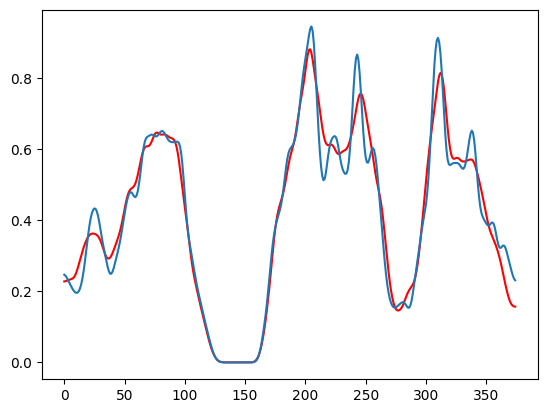

In [19]:
plt.plot(ldos_test_pred[120], "r")
plt.plot(ldos_test[120])

In [20]:
plt.plot(en, ldos_test_pred[53],'r')
plt.plot(en, ldos_test[53])

In [21]:
frames_all = ase_io.read('data/frames_C_all.xyz', ":")

##########################
for frame in frames_all:
    frame.wrap(eps=1e-12)
##########################
nframes_all = len(frames_all)
natoms_all = np.zeros(nframes_all, dtype=int)
for i in range(nframes_all):
    natoms_all[i] = len(frames_all[i])

nenv_all = np.sum(natoms_all)


In [22]:

file_path = 'data/frames_C_all.xyz'
atoms = extract_atom_symbols(file_path)

atoms_1 = np.atleast_1d(atoms)

# Find indices for each atom type
indices_Si_all = np.where(atoms_1 == 'Si')[0]
indices_C_all = np.where(atoms_1 == 'C')[0]


In [23]:
dos_ref_all = np.zeros((nframes_all, len(en)))
k = 0
for i in range(nframes_all):
    dos_ref_all[i] = np.mean(ldos_all_c[k:k+natoms_all[i]], axis=0)
    k += natoms_all[i]

In [24]:
prefix = "Silicon"

HYPERS = {
    'soap_type': 'PowerSpectrum',
    'interaction_cutoff': 6.,
    'max_radial': 12,
    'max_angular': 9,
    'gaussian_sigma_constant': 0.45,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.45,
    'radial_basis': 'GTO',
    'normalize' : True,
    'cutoff_function_type': 'RadialScaling',
    'cutoff_function_parameters': {'rate': 1.,
        'scale': 3.,
        'exponent': 5,
        'interaction_cutoff': 6.,
        'cutoff_smooth_width': 0.45},
}
########################## definition of number of train and test frames using its numbers
np.random.seed(1234)
ntrain = int(0.8*nframes_all)
itrain = np.arange(nframes_all)
np.random.shuffle(itrain)
itest = itrain[ntrain:]
itrain = itrain[:ntrain]
######################### definition of number of sparse environments and atomic number and zeta
n_sparse = {6: 150, 14: 150}
nref = 300
######################### 
zeta = 2
######################### make features and sparse them as "X_sparse_features"
soap = SOAP(**HYPERS)
sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
start = time()
managers = soap.transform(frames_all)
X_sparse = sparse.select_and_filter(managers)
print ("Execution: ", time()-start)
features = managers.get_features(soap)
X_sparse_features = X_sparse._sparse_points.get_features()
######################### detrmination kMM
## get kMM
kMM = (X_sparse_features @ X_sparse_features.T)**zeta
######################### detrminate kNM
## get kNM
kNM = np.zeros((nframes_all, nref))

k = 0
for i in tnrange(nframes_all):
    ifeatures = features[k: k+natoms_all[i]]
    k += natoms_all[i]
    kNM[i] = ((ifeatures @ X_sparse_features.T)**zeta).sum(axis=0)
    kNM[i] /= natoms_all[i]
#########################
sigma_dos, weights_dos, dos_dos_pred = do_krr(kNM, kMM, itrain, itest, dos_ref_all)


Execution:  0.33864593505859375


  0%|          | 0/46 [00:00<?, ?it/s]

In [25]:
np.random.seed(1234)
loss_l = []
loss_d = []
env_values = np.arange(20, 480, 40)
n_rs = 5
zeta = 2
for l in tnrange(n_rs):
    
    loss_1 = []
    loss_2 = []

    for i in env_values:#tqdm(env_values, desc="Processing"):
        nref = int(i)
        n_sparse = {6: int(i/2), 14: int(i/2)}
        sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
        
        #########################
        managers = soap.transform(frames_all)
        X_sparse = sparse.select_and_filter(managers)
        features = managers.get_features(soap)
        X_sparse_features = X_sparse._sparse_points.get_features()
        #########################
        kMM = np.zeros((nref, nref))
        kMM = (X_sparse_features @ X_sparse_features.T)**zeta
    
        rn = np.random.randint(0, nenv_all, i)
        #########################
        ntrain = int(i)
        itrain = rn
        # set test without training ones
        itest = np.setdiff1d(np.arange(nenv_all), rn)
        ## get kNM
        kNM = np.zeros((nenv_all, nref))
        kNM = (features @ X_sparse_features.T)**zeta
    
        ######################
        sigma_pw, weights_1, ml_ldos = do_krr(kNM, kMM, itrain, itest, ldos_all_c)
        loss_1.append(get_dos_rmse(ml_ldos, ldos_all_c, en, perc=False))
        
        ntrain = int(i/10)
        itrain = np.arange(nframes_all)
        np.random.shuffle(itrain)
        itest = itrain[ntrain:]
        itrain = itrain[:ntrain]
        
        kNM_dos, kMM_dos = KNM_DOS(frames_all, natoms_all, X_sparse_features)
        sigma_pw, weights_2, ml_dos_BM = do_krr(kNM_dos, kMM_dos, itrain, itest, dos_ref_all)
        loss_2.append(get_dos_rmse(ml_dos_BM, dos_ref_all, en, perc=False))
        
    loss_l.append(loss_1)
    loss_d.append(loss_2)
loss_ldos = np.mean(loss_l, axis=0)
loss_dos = np.mean(loss_d, axis=0)


  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:

plt.plot(env_values, loss_ldos, 'ro-', label = "Trained on LDOS")
plt.plot(env_values[2:], loss_dos[2:], 'o-', color="orange", label="Trained on DOS")
plt.xlabel("Train-Set Size (# of Env.)", size=20)
plt.ylabel("Normalized Loss of LDOS", size=20)
plt.title("Set C", size=25)
plt.xticks([100, 300, 500], ['100','300','500'], size=20)
plt.legend(fontsize=20)

# Disable transparency for EPS output
fig = plt.gcf()
for artist in fig.findobj():
    try:
        artist.set_alpha(1)
    except AttributeError:
        pass

plt.savefig("learn_set_C.png", bbox_inches='tight')


## Investigating Locality in Hybrid Functional Calculations of Local Electronic DOS 

In [28]:
np.random.seed(1234)

nref = 400
n_sparse = {14: 200, 6:200}
#########################
zeta = 2
range_rcut = np.arange(2.4, 6.0, 0.50)
rn = len(range_rcut)
Li = np.empty((0, rn))
Li_c = np.empty((0, rn))
Li_si = np.empty((0, rn))
iteration = 5
for l in tnrange(iteration):
    Li_0 = []
    Li_c_0 = []
    Li_si_0 = []
    # for cut in tqdm(np.arange(3.0, 8.5, 0.50), desc="Processing"):
    for cut in range_rcut:
        HYPERS = {
            'soap_type': 'PowerSpectrum',
            'interaction_cutoff': cut,
            'max_radial': 12,
            'max_angular': 9,
            'gaussian_sigma_constant': 0.45,
            'gaussian_sigma_type': 'Constant',
            'cutoff_smooth_width': 0.45,
            'radial_basis': 'GTO',
            'normalize' : True,
            'cutoff_function_type': 'RadialScaling',
            'cutoff_function_parameters': {'rate': 1.,
                'scale': 3.,
                'exponent': 5,
                'interaction_cutoff': cut,
                'cutoff_smooth_width': 0.45},
        }
        np.random.seed(1234)
        # Generate a random index between 0 and 402 inclusive
        index = np.random.randint(nenv_all)
        ntrain = int(0.8*nenv_all)
        itrain = np.arange(nenv_all)
        np.random.shuffle(itrain)
        itest = itrain[ntrain:]
        itrain = itrain[:ntrain]
        
        #########################
        soap = SOAP(**HYPERS)
        sparse = FPSFilter(soap, n_sparse, act_on='sample per species')
        managers = soap.transform(frames_all)
        X_sparse = sparse.select_and_filter(managers)
        features = managers.get_features(soap)
        X_sparse_features = X_sparse._sparse_points.get_features()
        #########################
        ## get kMM
        kMM = (X_sparse_features @ X_sparse_features.T)**zeta
        #########################
        ## get kNM
        kNM = np.zeros((nenv_all, nref))
        
        for i in range(nenv_all):
            kNM[i] = (features[i] @ X_sparse_features.T)**zeta
        # ######################
        sigma_pw, weights, ldos_alll_prd = do_krr(kNM, kMM, itrain, itest, ldos_all_c)
        ######################        
        Li_0.append(get_dos_rmse(ldos_alll_prd, ldos_all_c, en, perc=False))
        Li_c_0.append(get_dos_rmse(ldos_alll_prd[indices_C_all], ldos_all_c[indices_C_all], en, perc=False))
        Li_si_0.append(get_dos_rmse(ldos_alll_prd[indices_Si_all], ldos_all_c[indices_Si_all], en, perc=False))
    Li = np.vstack((Li, Li_0))
    Li_c = np.vstack((Li_c, Li_c_0))
    Li_si = np.vstack((Li_si, Li_si_0))
print('end')    

  0%|          | 0/5 [00:00<?, ?it/s]

end


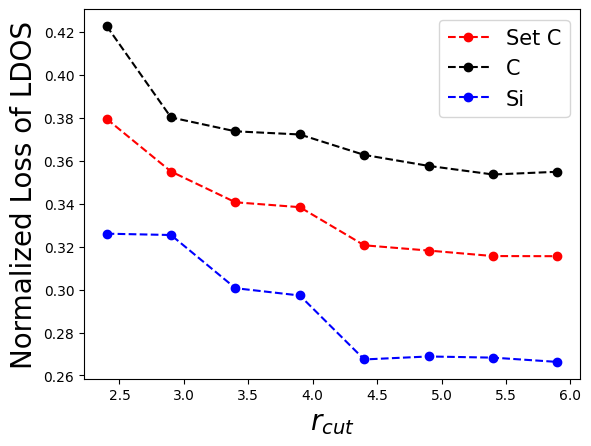

In [30]:
plt.plot(range_rcut,np.mean(Li, axis=0), "ro--", label="Set C")
plt.plot(range_rcut,np.mean(Li_c, axis=0), "ko--", label="C")
plt.plot(range_rcut,np.mean(Li_si, axis=0), "bo--", label="Si")
plt.xlabel("$r_{cut}$",size=20)
plt.ylabel("Normalized Loss of LDOS",size=20)
plt.legend(fontsize=15)